In [1]:
import numpy as nu
import matplotlib.pyplot as plt
from galpy.potential import SCFPotential, HernquistPotential,NFWPotential, compute_coeffs_spherical,compute_coeffs_axi
from IPython.display import display, Math, Latex
%matplotlib inline  

#SCFPotential

## Examples

### Spherical density 

Consider $\rho (r) = \frac{1}{2\pi} \frac{1}{r (1 + r)^3}$

We get $A_{nlm} = \delta_{n0}\delta_{l0}\delta_{m0}$

In [2]:
def rho_Spherical(r, a=1.):
    return (2*nu.pi)**-1 * ((r/a)*(a + r)**3)**-1

In [3]:
Acos, Asin = compute_coeffs_spherical(rho_Spherical,2)

Creating the SCFPotential object

In [4]:
scf = SCFPotential(1., Acos, Asin, 2.)

In [5]:
def calculateSCFDensity(r):
    density = nu.zeros(len(r), float)
    for i in range(len(r)):
        density[i] = scf.dens(r[i], 0)
    return density

In [6]:
R = nu.linspace(0.001, .1, 1000)
density = calculateSCFDensity(R)
densityAnalytic = rho_Spherical(R, 2.)

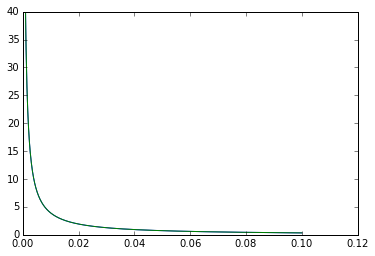

In [7]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

We confirm that our numerical density matches with our analytic density

#### Comparing to Hernquist potential

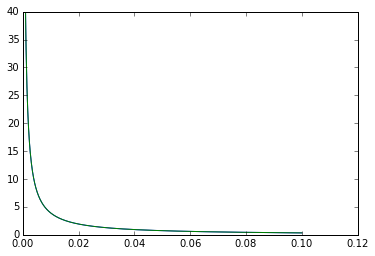

In [8]:
h = HernquistPotential(2., 2.) ## Equation (2.1) and the implemented Hernquist amplitude has a factor 2 difference
z = nu.zeros(len(R))
hDensity = h.dens(R,z)
plt.plot(R, density)
plt.plot(R, hDensity)

Confirmed that the implemented SCF potential matches with the already implemented Hernquist potential.

The only note is amp=2. 

### Zeeuw's perfect ellipsoid

Consider $\rho (r) = \frac{3}{4\pi} \frac{1}{(1 + r)^4}$

We get $A_{nlm} = \frac{3}{4}\delta_{n0}\delta_{l0}\delta_{m0} + \frac{1}{12}\delta_{n1}\delta_{l0}\delta_{m0}$

In [9]:
def rho_Zeeuw(r):
    return 3./(4*nu.pi) * (1 + r)**-4.

In [10]:
Acos, Asin = compute_coeffs_spherical(rho_Zeeuw, 10,1) 
scf = SCFPotential(1., Acos, Asin, 1)

TypeError: compute_coeffs_spherical() takes exactly 2 arguments (3 given)

In [ ]:
density = calculateSCFDensity(R)
densityAnalytic = rho_Zeeuw(R)


In [ ]:
plt.plot(R, density)
plt.plot(R, densityAnalytic)

### NFW potential

Consider $\rho (r) = \frac{1}{4\pi} \frac{1}{r (1 + r)^2}$

In [15]:
def rho_NFW(r, a=1.):
    return (4*nu.pi*a**3)**-1. * ((r/a)*(1. + r/a)**2)**-1.

In [16]:
a = .01
Acos, Asin = compute_coeffs_spherical(rho_NFW,1)
scf = SCFPotential(1., Acos, Asin, a)

In [17]:
density = calculateSCFDensity(R)

In [18]:
nfw = NFWPotential(1., a)
nfwDensity = nfw.dens(R,z)

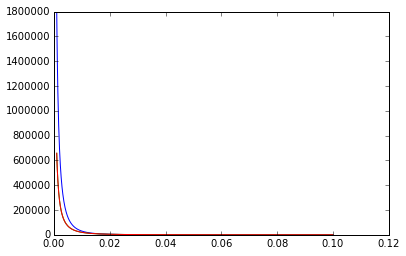

In [19]:
plt.plot(R, density)
plt.plot(R, nfwDensity)
plt.plot(R, rho_NFW(R, a))

As we can see, the function does not match well enough. Let's try increasing the size of the coefficients 

In [20]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,4,1.)
scf = SCFPotential(1., Acos, Asin,a)
density = calculateSCFDensity(R)

TypeError: compute_coeffs_spherical() takes exactly 2 arguments (3 given)

In [ ]:
plt.plot(R, density)
plt.plot(R, nfwDensity)

It got worse. Let's try increasing it again...

In [ ]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,10,1.)
scf = SCFPotential(1., Acos, Asin,a)
density = calculateSCFDensity(R)

In [ ]:
plt.plot(R, density)
plt.plot(R, nfwDensity)

Slightly better. Let's try one more time..

In [ ]:
Acos, Asin = compute_coeffs_spherical(rho_NFW,100,1)
scf = SCFPotential(1., Acos, Asin,a)
density = calculateSCFDensity(R)

In [ ]:
plt.plot(R, density)
plt.plot(R, nfwDensity)

### Axisymmetric density

We'll check if compute_coeffs_axi generalizes to compute_coeffs_spherical for a spherical function, as we expect it to.

First, some usefull functions that is unique to spherical densities

In [ ]:
epi = 1e-14
def test_Acosn(As, Aa):
    return nu.all(As[0] - Aa[0][:,:1,:1] < epi)
def test_Acos_nbiggerthan0(Aa):
    return nu.all(nu.fabs(Aa[0][:,1:,1:]) <epi)
def test_Asin_allZero(As, Aa):
    return nu.all(nu.fabs(As[1]) < epi) and nu.all(nu.fabs(Aa[1]) < epi)

def test_all(As,Aa):
    return test_Acosn(As,Aa) and test_Acos_nbiggerthan0(Aa) and test_Asin_allZero(As,Aa)


rho_Spherical

In [23]:
Aspherical = compute_coeffs_spherical(rho_Spherical,10)
Aaxi = compute_coeffs_axi(rho_Spherical, 10, 10)
print test_all(Aspherical,Aaxi)

True


Zeeuw's perfect ellipsoid

In [22]:
Aspherical = compute_coeffs_spherical(rho_Zeeuw,10)
Aaxi = compute_coeffs_axi(rho_Zeeuw, 10, 10)
print test_all(Aspherical,Aaxi)

True


NFW

In [21]:
Aspherical = compute_coeffs_spherical(rho_NFW,10)
Aaxi = compute_coeffs_axi(rho_NFW, 10, 10)
print test_all(Aspherical,Aaxi)

True
